<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe. </font>

<font color='black'>The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe. </font>

<font color='black'>Step 1.1</font>

In [2]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
import utils
from utils import load_data
from utils import scale
from utils import apply_masks
from utils import do_prediction
from utils import calculate_band_indices
from sklearn.ensemble import RandomForestClassifier
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
from shapely.geometry import box

In [3]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [4]:
ba_gdf = gpd.read_file("bootless_bay.geojson")
ba_gdf = ba_gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = ba_gdf.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]

In [166]:
min_lon = 177.415519953916
min_lat = -17.61336539049535
max_lon = 177.46341277889703
max_lat = -17.576247293553328

bbox = [min_lon, min_lat, max_lon, max_lat]

In [167]:
datetime="2024"
items = list(client.search(collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox).items())

In [168]:
from pystac import Collection

In [169]:
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [170]:
data = load(
        items,
        measurements=[
            "nir", "red", "blue", "green", "emad", "smad", 
            "bcmad", "count", "green", "nir08", 
            "nir09", "swir16", "swir22", "coastal",
            "rededge1", "rededge2", "rededge3", 
        ],
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [171]:
# dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
# configure_s3_access(cloud_defaults=True, requester_pays=True)

In [172]:
scaled = (data.where(data != 0) * 0.0001).clip(0, 1)

In [173]:
mndwi = (scaled["green"]-scaled["swir16"])/(scaled["green"]+scaled["swir16"])
mndwi_land_mask = mndwi > 0
clipped_ds = scaled.where(mndwi_land_mask)

In [174]:
ndti = (clipped_ds["red"]-clipped_ds["green"])/(clipped_ds["red"]+clipped_ds["green"])
ndti_mask = ndti < 0.2
clipped_ds = clipped_ds.where(ndti_mask)

In [175]:
nir = clipped_ds['nir']
nir_mask = nir < 0.085
clipped_ds = clipped_ds.where(nir_mask)

In [176]:
all_masks = (mndwi_land_mask+ndti_mask+nir_mask)

In [177]:
# Incorporate other band ratios and indices
cai = (clipped_ds["coastal"]-clipped_ds["blue"])/( clipped_ds["coastal"]+ clipped_ds["blue"]) #coastal aerosol index
ndvi = (clipped_ds["nir"]-clipped_ds["red"])/( clipped_ds["nir"]+ clipped_ds["red"]) #vegetation index (NDVI)
ndwi = (clipped_ds["green"]-clipped_ds["nir"])/(clipped_ds["green"]+clipped_ds["nir"]) #water index (NDWI)
b_g = (clipped_ds["blue"])/(clipped_ds["green"]) #blue to green ratio
b_r = (clipped_ds["blue"])/(clipped_ds["red"]) #blue to red ratio
mci = (clipped_ds["nir"])/(clipped_ds["rededge1"]) # max chlorophlyll index (MCI)
ndci = (clipped_ds["rededge1"]-clipped_ds["red"])/(clipped_ds["rededge1"]+clipped_ds["red"]) # normalised difference chlorophyll index (NDCI)


In [178]:
clipped_ds['cai'] = cai
clipped_ds['ndvi'] = ndvi
clipped_ds['ndwi'] = ndwi
clipped_ds['mndwi'] = mndwi
clipped_ds['ndti'] = ndti
clipped_ds['b_g'] = b_g
clipped_ds['b_r'] = b_r
clipped_ds['mci'] = mci
clipped_ds['ndci'] = ndci
# clipped_ds

In [179]:
# clipped_da = clipped_ds.squeeze().to_array(dim="band")
# clipped_da = clipped_da.astype('float32')
# clipped_da.odc.write_cog("clipped_ds_masked.tiff")

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data. 

Step 1.2. Input the training data to sample geomad data from the postcard
The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data. 
The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.
Step 1.2. Input the training data to sample geomad data from the postcard

In [180]:
# Define training data
ba_gdf = gpd.read_file("bootless_bay.geojson")
ba_gdf = ba_gdf.to_crs("EPSG:4326")
# ba_gdf.explore(column="cc_id", legend=True)

In [181]:
ba_postcard = clipped_ds#.where(all_masks)
# ba_postcard =clipped_ds.to_array(dim="band")
# First transform the training points to the same CRS as the data
ba_training = ba_gdf.to_crs(ba_postcard.odc.geobox.crs)

In [182]:
print(ba_training.columns)
ba_training=ba_training.drop(columns=['uuid', 'date', 'uuid'])

Index(['uuid', 'cc_id', 'observed', 'date', 'geometry'], dtype='object')


In [183]:
ba_training

,cc_id,observed,geometry
0,4,seagrass,POINT (-302092.206 -1057912.4)
1,4,seagrass,POINT (-302078.83 -1057913.449)
2,4,seagrass,POINT (-302078.478 -1057944.572)
3,4,seagrass,POINT (-302089.39 -1057922.891)
4,4,seagrass,POINT (-302062.638 -1057910.301)
...,...,...,...
815,10,land,POINT (-303113.729 -1059579.147)
816,10,land,POINT (-303119.481 -1059533.436)
817,10,land,POINT (-303119.481 -1059484.296)
818,10,land,POINT (-303136.735 -1059439.728)


In [184]:
ba_training_da = ba_training.assign(x=ba_training.geometry.x, y=ba_training.geometry.y).to_xarray()

In [185]:
ba_training_values = (
    ba_postcard.sel(ba_training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
ba_training_values

,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,time,cai,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci
index,,,,,,,,,,,,,,,,,,,,,
0,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
1,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
2,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
3,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
4,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
816,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
817,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,0.0118,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866


In [186]:
# Join the training data with the extracted values and remove unnecessary columns
ba_training_array = pd.concat([ba_training["cc_id"], ba_training_values], axis=1)
# Drop rows where there was no data available
ba_training_array = ba_training_array.dropna()
# Preview our resulting training array
ba_training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,time,cai,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci
0,4,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
1,4,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
2,4,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
3,4,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866
4,4,0.0206,0.0806,0.1115,0.1298,0.061958,0.000002,0.000016,0.0036,0.0157,...,2024-01-01,-0.089932,-0.592885,0.726064,0.838527,-0.23384,0.859014,1.383375,0.276139,-0.03866


In [187]:
# print(ba_training_array.columns)

In [188]:
# ba_training_array.to_csv("training_data/postcard_ba_dataframe.csv")

### Notebook 2 - Train Random Forest Machine Learning (ML) Model

Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model

Step 2.1. Concatenating all postcard dataframes<font color='black'>Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model</font>

<font color='black'>Step 2.1. Concatenating all postcard dataframes</font>

In [189]:
postcard_ba_df = gpd.read_file("joined_training_data_11042025_test.csv")
postcard_ba_df

,field_1,cc_id,nir,red,blue,green,emad,smad,bcmad,count,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,y,x
0,0,2,0.0298,0.032899998,0.055999998,0.0436,0.08867363,4.070756e-06,3.3468114e-05,0.0058,...,-0.049441766,0.18801092,0.24039832,-0.13986932,1.2844036,1.7021277,0.884273,0.012012049,-2044675.0,3153725.0
1,1,2,0.0295,0.0326,0.0559,0.043399997,0.08912841,3.7858456e-06,3.3206863e-05,0.0058,...,-0.04991949,0.19067211,0.23646721,-0.14210522,1.2880185,1.714724,0.8727811,0.018072259,-2044665.0,3153725.0
2,2,2,0.0289,0.032199997,0.0552,0.042999998,0.08345044,3.5213677e-06,3.508021e-05,0.0056,...,-0.05400979,0.19610569,0.2463768,-0.14361703,1.283721,1.7142859,0.8626865,0.019786963,-2044635.0,3153725.0
3,3,2,0.03,0.033299997,0.0565,0.0437,0.09336796,3.3604056e-06,3.2506323e-05,0.0058,...,-0.052132674,0.18588874,0.22580643,-0.13506496,1.2929062,1.6966968,0.85470086,0.0263158,-2044655.0,3153725.0
4,4,2,0.0297,0.032199997,0.0563,0.0435,0.08827729,4.1538833e-06,3.362744e-05,0.0058,...,-0.040387686,0.18852457,0.24285713,-0.14927347,1.2942529,1.7484473,0.8839286,0.021276617,-2044695.0,3153725.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16513,16513,8,0.057299998,0.0639,0.0799,0.076299995,0.13864477,1.4586091e-06,2.8264767e-05,0.003,...,-0.054455478,0.14221555,0.114682235,-0.088445045,1.0471822,1.2503911,0.8577844,0.022188196,-1057425.0,-302355.0
16514,16514,8,0.050499998,0.055099998,0.072299995,0.067,0.11928381,1.1002033e-06,2.6359545e-05,0.003,...,-0.0435606,0.14042556,0.13848773,-0.097461134,1.0791044,1.3121597,0.8767361,0.022182798,-1057625.0,-303005.0
16515,16515,8,0.058,0.062299997,0.08,0.0744,0.11123463,1.1610985e-06,2.3864643e-05,0.0033,...,-0.03574396,0.12386708,0.11963883,-0.08851502,1.0752687,1.2841092,0.8787879,0.028838683,-1058355.0,-302925.0
16516,16516,8,0.0547,0.058599997,0.073699996,0.0689,0.13072646,1.0475635e-06,2.6987886e-05,0.0029,...,-0.03442188,0.11488672,0.1095008,-0.080784306,1.0696661,1.2576792,0.89087945,0.023333356,-1058755.0,-302705.0


In [190]:
postcard_ba_df.columns


Index(['field_1', 'cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad',
       'bcmad', 'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal',
       'rededge1', 'rededge2', 'rededge3', 'cai', 'ndvi', 'ndwi', 'mndwi',
       'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'y', 'x'],
      dtype='object')

In [191]:
# postcard_ba_df.columns
# postcard_ba_df = postcard_ba_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
postcard_ba_df = postcard_ba_df.drop(columns=["field_1"])
postcard_ba_df = postcard_ba_df.drop(columns=["y", "x"])
postcard_ba_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,rededge3,cai,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci
0,2,0.0298,0.032899998,0.055999998,0.0436,0.08867363,4.070756e-06,3.3468114e-05,0.0058,0.0307,...,0.0325,0.058823552,-0.049441766,0.18801092,0.24039832,-0.13986932,1.2844036,1.7021277,0.884273,0.012012049
1,2,0.0295,0.0326,0.0559,0.043399997,0.08912841,3.7858456e-06,3.3206863e-05,0.0058,0.0307,...,0.0326,0.060504165,-0.04991949,0.19067211,0.23646721,-0.14210522,1.2880185,1.714724,0.8727811,0.018072259
2,2,0.0289,0.032199997,0.0552,0.042999998,0.08345044,3.5213677e-06,3.508021e-05,0.0056,0.0295,...,0.0316,0.053984568,-0.05400979,0.19610569,0.2463768,-0.14361703,1.283721,1.7142859,0.8626865,0.019786963
3,2,0.03,0.033299997,0.0565,0.0437,0.09336796,3.3604056e-06,3.2506323e-05,0.0058,0.0316,...,0.0335,0.060681637,-0.052132674,0.18588874,0.22580643,-0.13506496,1.2929062,1.6966968,0.85470086,0.0263158
4,2,0.0297,0.032199997,0.0563,0.0435,0.08827729,4.1538833e-06,3.362744e-05,0.0058,0.03,...,0.031799998,0.056951392,-0.040387686,0.18852457,0.24285713,-0.14927347,1.2942529,1.7484473,0.8839286,0.021276617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16513,8,0.057299998,0.0639,0.0799,0.076299995,0.13864477,1.4586091e-06,2.8264767e-05,0.003,0.062099997,...,0.063999996,-0.039011687,-0.054455478,0.14221555,0.114682235,-0.088445045,1.0471822,1.2503911,0.8577844,0.022188196
16514,8,0.050499998,0.055099998,0.072299995,0.067,0.11928381,1.1002033e-06,2.6359545e-05,0.003,0.0541,...,0.055299997,-0.01974609,-0.0435606,0.14042556,0.13848773,-0.097461134,1.0791044,1.3121597,0.8767361,0.022182798
16515,8,0.058,0.062299997,0.08,0.0744,0.11123463,1.1610985e-06,2.3864643e-05,0.0033,0.060999997,...,0.062699996,-0.04302477,-0.03574396,0.12386708,0.11963883,-0.08851502,1.0752687,1.2841092,0.8787879,0.028838683
16516,8,0.0547,0.058599997,0.073699996,0.0689,0.13072646,1.0475635e-06,2.6987886e-05,0.0029,0.057699997,...,0.0596,-0.036568206,-0.03442188,0.11488672,0.1095008,-0.080784306,1.0696661,1.2576792,0.89087945,0.023333356


Step 2.2. Train the ML model

In [192]:
# Support Vector Machines
from sklearn import svm
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create a pipeline for scaling and SVM
svm_model = make_pipeline(StandardScaler(), SVC(kernel="rbf", decision_function_shape="ovo"))


In [193]:
# The classes are the first column
classes = np.array(postcard_ba_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_ba_df)[:, 1:]

# Create a model...
# classifier = RandomForestClassifier()

# ...and fit it to the data
# model = clf.fit(observations, classes)

In [194]:
# Train the model
svm_model = svm_model.fit(observations, classes)

In [195]:
# Suppose 'model' is your trained model object
# joblib.dump(svm_model, "models/model-geomad-joined-data-svm-ovr-joined-15042025.model")


In [196]:
ba_postcard

<xarray.Dataset> Size: 23MB
Dimensions:      (time: 1, y: 432, x: 534)
Coordinates:
  * y            (y) float64 3kB -1.975e+06 -1.975e+06 ... -1.979e+06 -1.979e+06
  * x            (x) float64 4kB 3.052e+06 3.052e+06 ... 3.057e+06 3.057e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/25)
    nir          (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    red          (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    blue         (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    green        (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    emad         (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    smad         (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    ...           ...
    mndwi        (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    ndti         (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    b_g          (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    b_r          (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    mci          (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>
    ndci         (time, y, x) float32 923kB dask.array<chunksize=(1, 432, 534), meta=np.ndarray>

In [197]:
# Convert to a stacked array of observations
# stacked_arrays = stacked_arrays.squeeze()
stacked_arrays = ba_postcard.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays = stacked_arrays.to_dataarray()

In [198]:
# # Convert to a stacked array of observations
# # stacked_arrays = stacked_arrays.squeeze()
# stacked_arrays = ba_postcard.squeeze().stack(dims=["y", "x"]).transpose()
# stacked_arrays = stacked_arrays.to_dataarray()

In [199]:
stacked_arrays

<xarray.DataArray (variable: 25, y: 432, x: 534)> Size: 23MB
dask.array<stack, shape=(25, 432, 534), dtype=float32, chunksize=(1, 432, 534), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 3kB -1.975e+06 -1.975e+06 ... -1.979e+06 -1.979e+06
  * x            (x) float64 4kB 3.052e+06 3.052e+06 ... 3.057e+06 3.057e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 200B 'nir' 'red' 'blue' ... 'mci' 'ndci'

In [200]:
# stacked_arrays_2d

In [201]:
stacked_arrays_2d = stacked_arrays.stack(new_dim=("y", "x")) 

In [202]:
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [203]:
# stacked_arrays = stacked_arrays.reshape(-1, 26)
stacked_arrays_2d.shape


(25, 230688)

In [204]:
reordered_data_array = reordered_data_array.fillna(0)

In [205]:
# Predict the classes

predicted = svm_model.predict(reordered_data_array)


In [206]:
# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(ba_postcard.y), len(ba_postcard.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": ba_postcard.y, "x": ba_postcard.x}, dims=["y", "x"]
)

In [207]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

object


In [208]:
predicted_da

<xarray.DataArray (y: 432, x: 534)> Size: 923kB
array([[2., 2., 2., ..., 4., 4., 4.],
       [2., 2., 2., ..., 1., 1., 1.],
       [2., 2., 2., ..., 1., 1., 1.],
       ...,
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.],
       [2., 2., 2., ..., 2., 2., 2.]], dtype=float32)
Coordinates:
  * y        (y) float64 3kB -1.975e+06 -1.975e+06 ... -1.979e+06 -1.979e+06
  * x        (x) float64 4kB 3.052e+06 3.052e+06 ... 3.057e+06 3.057e+06

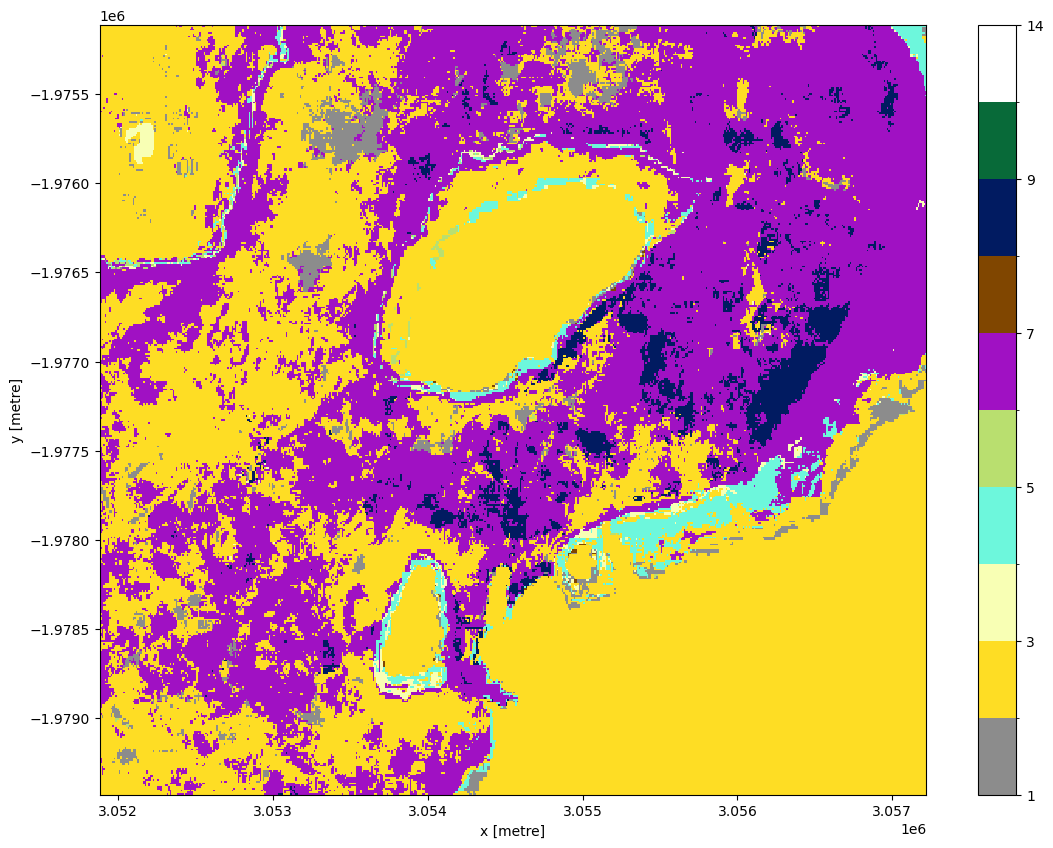

In [209]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [210]:
predicted_da.odc.explore()

In [214]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)

In [215]:
predicted_da.odc.explore(cmap=c_map)

In [213]:
predicted_da.odc.write_cog("predicted_svm_bekana_ovo_15042025.tiff", overwrite=True)

PosixPath('predicted_svm_bekana_ovo_15042025.tiff')